In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import random

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#sklearn modules
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

#Time Series
import datetime
from datetime import datetime
from datetime import timedelta
from time import time

#Statsmodels
import statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
df = pd.read_csv ('yiefldsamurai_data_curveDaiUsdcUsdt.csv'
                  , parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
df = df.asfreq(pd.infer_freq(df.index))

In [5]:
df.head()

,DAPR,TVL
Date,,
2020-09-06,0.24%,1.85
2020-09-07,0%,3.19
2020-09-08,0%,5.96
2020-09-09,0%,6.01
2020-09-10,0%,6.01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 585 entries, 2020-09-06 to 2022-04-13
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DAPR    585 non-null    object
 1   TVL     585 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB


In [7]:
df["DAPR"] = list(map(lambda x: x[:-1], df["DAPR"].values))

In [8]:
df["TVL"] = list(map(lambda x: x[:-1], df["TVL"].values))

In [9]:
df.head()

,DAPR,TVL
Date,,
2020-09-06,0.24,1.8
2020-09-07,0,3.1
2020-09-08,0,5.9
2020-09-09,0,6.0
2020-09-10,0,6.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 585 entries, 2020-09-06 to 2022-04-13
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DAPR    585 non-null    object
 1   TVL     585 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB


In [15]:
df['DAPR'] = [float(x) for x in df['DAPR'].values]
df['TVL'] = [float(x) for x in df['TVL'].values]

In [16]:
DAPR_series = df.DAPR

In [17]:
DAPR_series

Date
2020-09-06    0.24
2020-09-07    0.00
2020-09-08    0.00
2020-09-09    0.00
2020-09-10    0.00
              ... 
2022-04-09    0.47
2022-04-10    0.48
2022-04-11    0.52
2022-04-12    0.49
2022-04-13    0.47
Freq: D, Name: DAPR, Length: 585, dtype: float64

# Time Series Pre-Processing

In [18]:
# Get the Peaks and Troughs
doublediff = np.diff(np.sign(np.diff(df.DAPR)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*df.DAPR)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

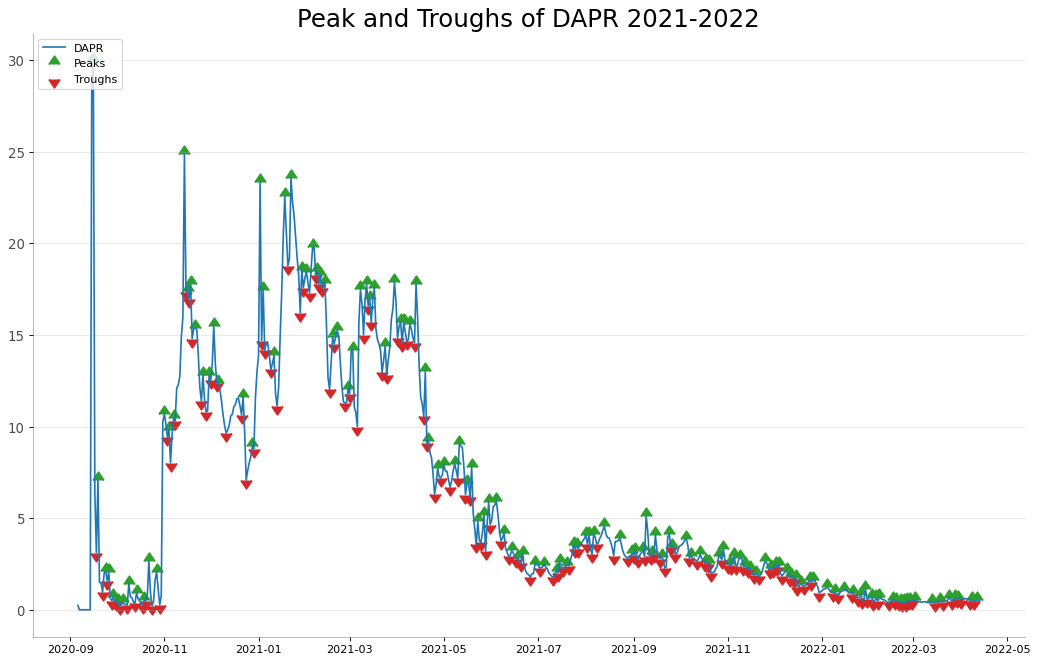

In [19]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(df.DAPR.index, 'DAPR', data=df, color='tab:blue', label='DAPR')
plt.scatter(df.index[peak_locations], df.DAPR[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
plt.scatter(df.index[trough_locations], df.DAPR[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')

# Decoration
plt.title("Peak and Troughs of DAPR 2021-2022", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [34]:
def plot_series(series):
    plt.figure(figsize=(16,10), dpi=80)
    plt.plot(DAPR_series, color='red')
    plt.ylabel('DAPR %', fontsize=16)

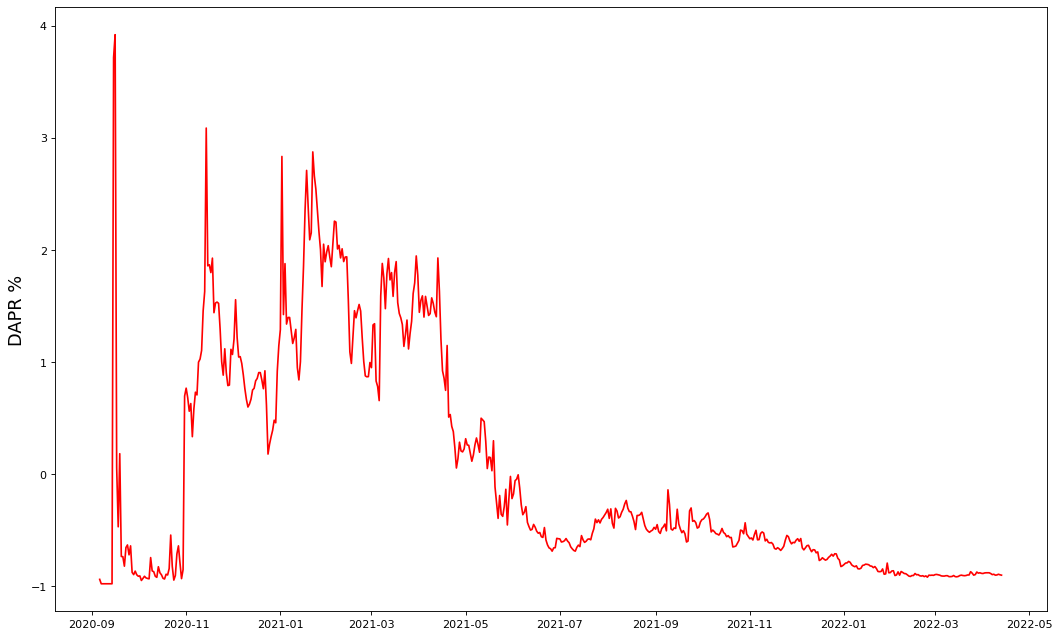

In [35]:
plot_series(DAPR_series)

## Normalize

In [36]:
avg, dev = DAPR_series.mean(), DAPR_series.std()

In [37]:
DAPR_series = (DAPR_series - avg) / dev

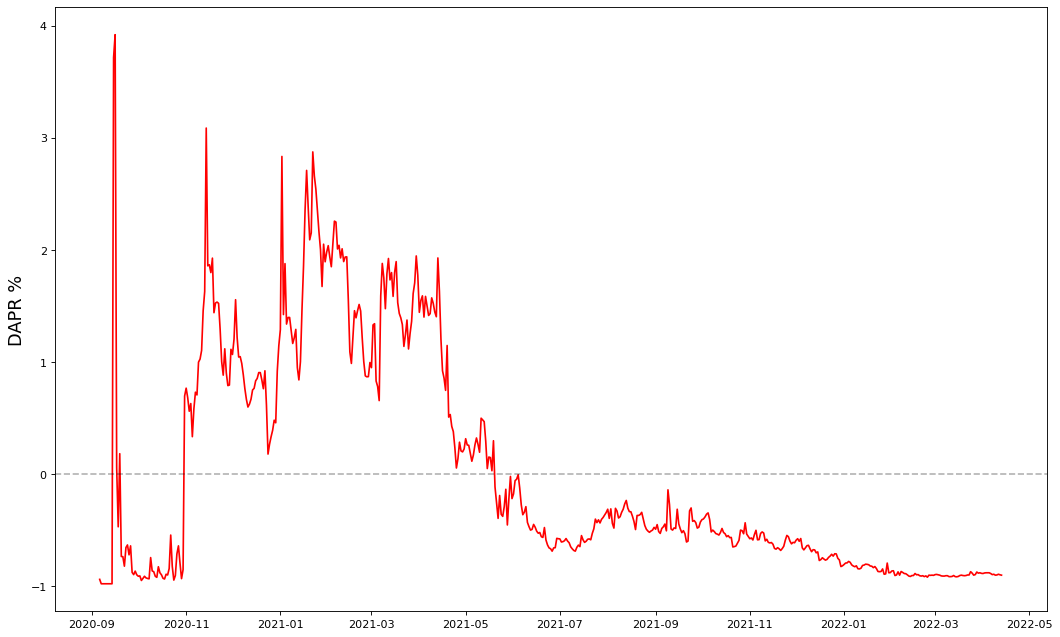

In [38]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## First Difference to Remove Trend

In [39]:
DAPR_series = DAPR_series.diff().dropna()

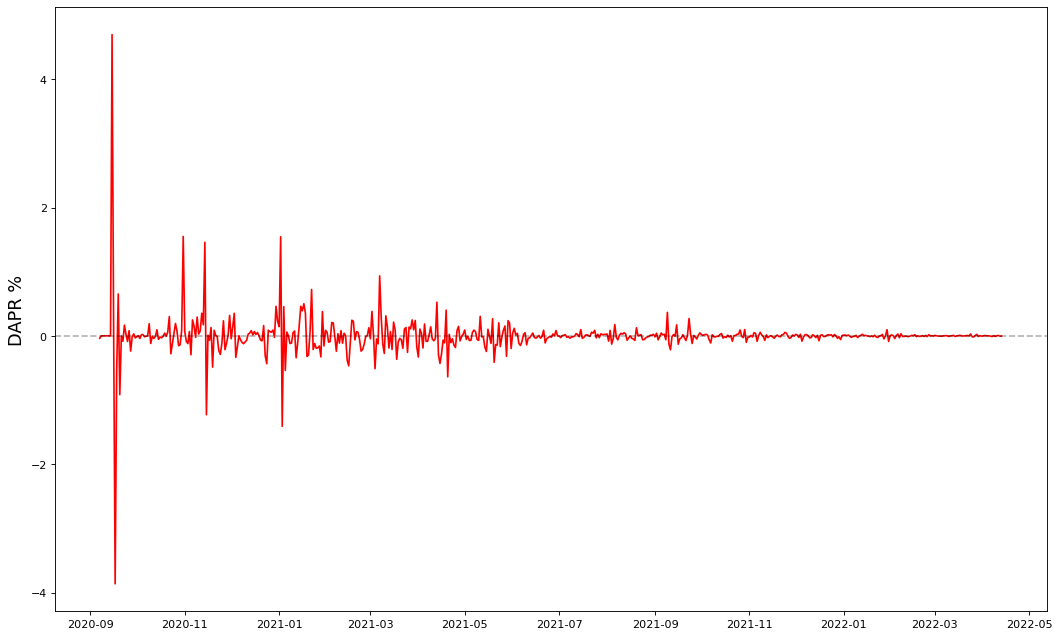

In [40]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Increasing Volatility (Monthly)

In [45]:
monthly_volatility = DAPR_series.groupby(DAPR_series.index.month).std()

In [46]:
monthly_volatility

Date
1     0.338621
2     0.121955
3     0.189684
4     0.188559
5     0.169629
6     0.064093
7     0.033136
8     0.061637
9     0.857962
10    0.213229
11    0.283626
12    0.126860
Name: DAPR, dtype: float64

In [47]:
DAPR_monthly_vol = DAPR_series.index.map(lambda d: monthly_volatility.loc[d.month])

In [48]:
DAPR_monthly_vol

Float64Index([ 0.8579618008032313,  0.8579618008032313,  0.8579618008032313,
               0.8579618008032313,  0.8579618008032313,  0.8579618008032313,
               0.8579618008032313,  0.8579618008032313,  0.8579618008032313,
               0.8579618008032313,
              ...
              0.18855863334865428, 0.18855863334865428, 0.18855863334865428,
              0.18855863334865428, 0.18855863334865428, 0.18855863334865428,
              0.18855863334865428, 0.18855863334865428, 0.18855863334865428,
              0.18855863334865428],
             dtype='float64', name='Date', length=584)

In [49]:
DAPR_series = DAPR_series / DAPR_monthly_vol

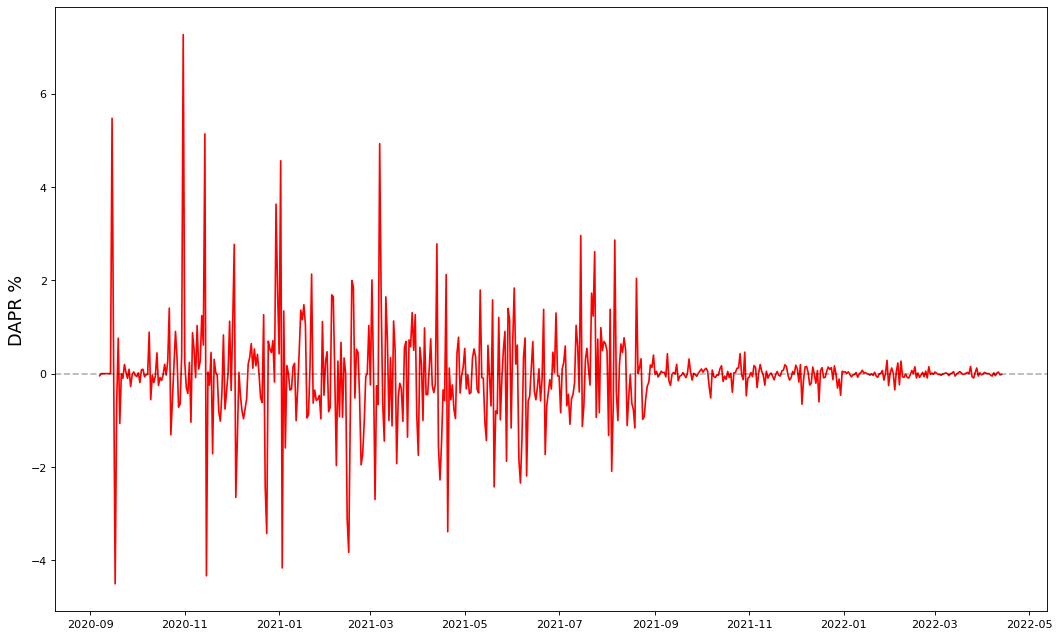

In [50]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Remove Seasonality (Weekly)

In [51]:
weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()

<ipython-input-51-18f982a98f72>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_avgs = DAPR_series.groupby(DAPR_series.index.week).mean()


In [52]:
weekly_avgs

Date
1    -0.048936
2     0.242957
3     0.025846
4    -0.120617
5     0.003215
6    -0.270796
7    -0.023922
8    -0.298545
9     0.220518
10    0.079977
11   -0.175334
12    0.108277
13   -0.074036
14    0.009902
15   -0.371700
16   -0.524811
17    0.158997
18    0.004128
19   -0.094937
20   -0.288937
21    0.143093
22   -0.290293
23   -0.487957
24   -0.160225
25   -0.207564
26    0.104596
27   -0.401473
28    0.380343
29    0.718425
30    0.455544
31   -0.181754
32    0.132529
33   -0.060585
34   -0.340788
35    0.074098
36   -0.002448
37   -0.003672
38    0.027747
39    0.002402
40   -0.062516
41    0.010946
42   -0.041593
43    0.030648
44    0.547030
45   -0.022629
46    0.273197
47   -0.069534
48   -0.206790
49    0.034237
50   -0.260324
51    0.123263
52   -0.308508
53    0.967134
dtype: float64

In [53]:
DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])

<ipython-input-53-6d50e57be64c>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  DAPR_weekly_avg = DAPR_series.index.map(lambda d: weekly_avgs.loc[d.week])


In [54]:
DAPR_weekly_avg

Float64Index([-0.0036723952125250576, -0.0036723952125250576,
              -0.0036723952125250576, -0.0036723952125250576,
              -0.0036723952125250576, -0.0036723952125250576,
              -0.0036723952125250576,    0.02774698605018933,
                 0.02774698605018933,    0.02774698605018933,
              ...
                0.009902096658506864,   0.009902096658506864,
                0.009902096658506864,   0.009902096658506864,
                0.009902096658506864,   0.009902096658506864,
                0.009902096658506864,    -0.3716999533186988,
                 -0.3716999533186988,    -0.3716999533186988],
             dtype='float64', name='Date', length=584)

In [55]:
DAPR_series = DAPR_series - DAPR_weekly_avg

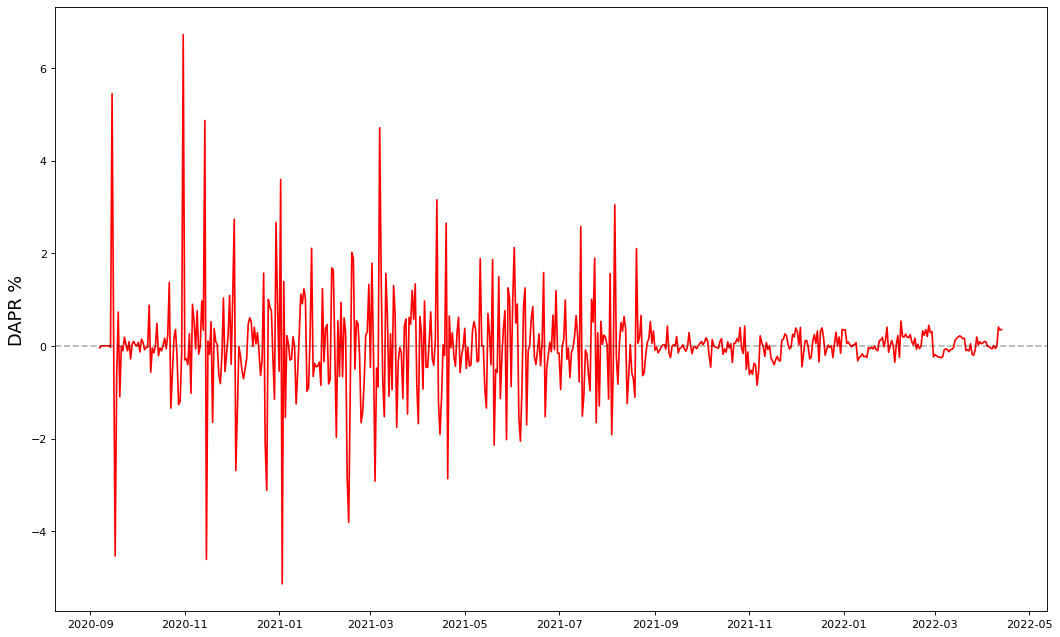

In [60]:
plot_series(DAPR_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

## Checking Stationarity (ADF Test)

In [62]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [63]:
#check stationarity
perform_adf_test(DAPR_series)

ADF Statistic: -5.642568
p-value: 0.000001


# ARIMA Modeling

## ACF Plot

<BarContainer object of 20 artists>

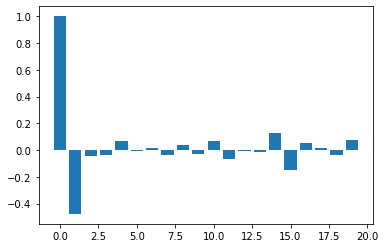

In [92]:
first_diff = DAPR_series.diff()[1:]
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:int(num_lags)])

## PACF

<BarContainer object of 15 artists>

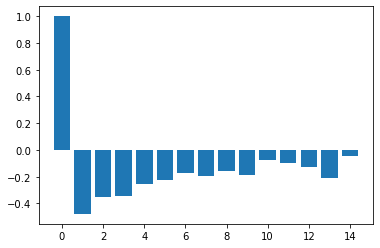

In [97]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:int(num_lags)])

## Training/Test Sets

In [98]:
train_end = datetime(2021,11,1)
test_end = datetime(2022,5,1)

train_data = DAPR_series[:train_end]
test_data = DAPR_series[train_end + timedelta(days=1):test_end]

## Fit ARIMA Model

In [99]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [100]:
#fit the model
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.7930397987365723


In [101]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 None   No. Observations:                  421
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -813.064
Date:                              Fri, 29 Apr 2022   AIC                           1632.128
Time:                                      16:14:15   BIC                           1644.249
Sample:                                  09-07-2020   HQIC                          1636.919
                                       - 11-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7940      0.152     -5.221      0.000      -1.092      -0.496
ma.S.L12       0.87

In [111]:
#get the predictions and residuals
#fit the model

##Model Selection

#create AR(p) model

# GARCH Modelling

In [66]:
from arch import arch_model

## PACF

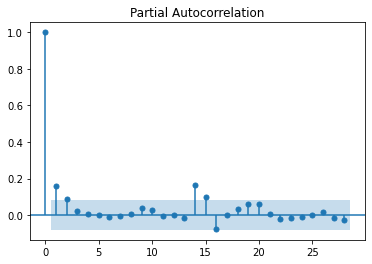

In [68]:
plot_pacf(DAPR_series**2)
plt.show()

## Fit GARCH(3,3)

In [70]:
model = arch_model(DAPR_series, p=3, q=3)

In [71]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4227.192248523598
Iteration:      2,   Func. Count:     23,   Neg. LLF: 68120.15018890257
Iteration:      3,   Func. Count:     33,   Neg. LLF: 787.3898561638077
Iteration:      4,   Func. Count:     43,   Neg. LLF: 720.0072703034035
Iteration:      5,   Func. Count:     53,   Neg. LLF: 649.0294227634051
Iteration:      6,   Func. Count:     63,   Neg. LLF: 605.2120772970713
Iteration:      7,   Func. Count:     73,   Neg. LLF: 601.837049672095
Iteration:      8,   Func. Count:     83,   Neg. LLF: 614.734675155368
Iteration:      9,   Func. Count:     93,   Neg. LLF: 608.5657152284527
Iteration:     10,   Func. Count:    103,   Neg. LLF: 596.8293590353217
Iteration:     11,   Func. Count:    113,   Neg. LLF: 591.3130224010722
Iteration:     12,   Func. Count:    122,   Neg. LLF: 590.9458158906523
Iteration:     13,   Func. Count:    131,   Neg. LLF: 591.033147126054
Iteration:     14,   Func. Count:    141,   Neg. LLF: 590.913714853

In [72]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -590.907
Distribution:                  Normal   AIC:                           1197.81
Method:            Maximum Likelihood   BIC:                           1232.77
                                        No. Observations:                  584
Date:                Fri, Apr 29 2022   Df Residuals:                      583
Time:                        15:55:54   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0237  1.560e-02      1.517      0.129 [-6.911e-03,5.426e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.9292e-03  2.385e-03      1.228      0.219 [-1.746e-03,7.604e-03]
alpha[1]       0.1193  7.060e-02      1.690  9.106e-02   [-1.907e-02,  0.258]
alpha[2]       0.0711  5.551e-02      1.281      0.200   [-3.768e-02,  0.180]
alpha[3]       0.1072  6.817e-02      1.572      0.116   [-2.646e-02,  0.241]
beta[1]    2.7254e-08      0.222  1.226e-07      1.000      [ -0.436,  0.436]
beta[2]        0.1997      0.263      0.761      0.447      [ -0.315,  0.714]
beta[3]        0.5027      0.181      2.774  5.529e-03      [  0.148,  0.858]
=============================================================================

Covariance estimator: robust
"""

## Try GARCH(3,0) = ARCH(3)

In [74]:
model = arch_model(DAPR_series, p=3, q=0)

In [75]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2888.284816762638
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1532.3515597296796
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2477.784486037256
Iteration:      4,   Func. Count:     33,   Neg. LLF: 159480.49097907025
Iteration:      5,   Func. Count:     40,   Neg. LLF: 5174.774827300058
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1688.9081535634198
Iteration:      7,   Func. Count:     54,   Neg. LLF: 29900.100863361607
Iteration:      8,   Func. Count:     61,   Neg. LLF: 718.5685602347803
Iteration:      9,   Func. Count:     68,   Neg. LLF: 817.0788823910901
Iteration:     10,   Func. Count:     75,   Neg. LLF: 723.8169079591225
Iteration:     11,   Func. Count:     82,   Neg. LLF: 702.4041879896829
Iteration:     12,   Func. Count:     88,   Neg. LLF: 701.1204369082277
Iteration:     13,   Func. Count:     94,   Neg. LLF: 700.8900316407824
Iteration:     14,   Func. Count:    100,   Neg. LLF: 700.71

In [76]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -700.709
Distribution:                  Normal   AIC:                           1411.42
Method:            Maximum Likelihood   BIC:                           1433.27
                                        No. Observations:                  584
Date:                Fri, Apr 29 2022   Df Residuals:                      583
Time:                        15:56:41   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0392  3.284e-02      1.194      0.233 [-2.516e-02,  0.104]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2566      0.167      1.534      0.125 [-7.119e-02,  0.584]
alpha[1]       0.3279  9.728e-02      3.371  7.498e-04    [  0.137,  0.519]
alpha[2]       0.4386      0.333      1.318      0.187    [ -0.214,  1.091]
alpha[3]       0.2335      0.145      1.608      0.108 [-5.109e-02,  0.518]
===========================================================================

Covariance estimator: robust
"""

In [ ]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = DAPR_series[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [80]:
rolling_predictions = pd.Series(rolling_predictions, index=DAPR_series.index[-365:])

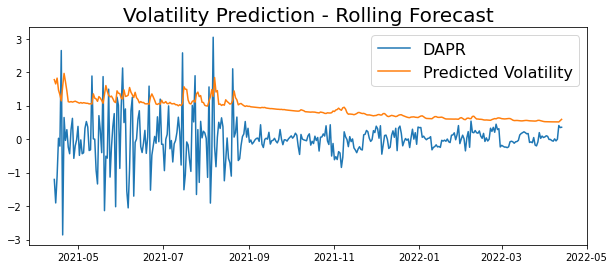

In [86]:
plt.figure(figsize=(10,4))
true, = plt.plot(DAPR_series[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['DAPR', 'Predicted Volatility'], fontsize=16)

## Using the Model

In [102]:
train = DAPR_series
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')

In [106]:
pred = model_fit.forecast(horizon=7)
future_dates = [DAPR_series.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

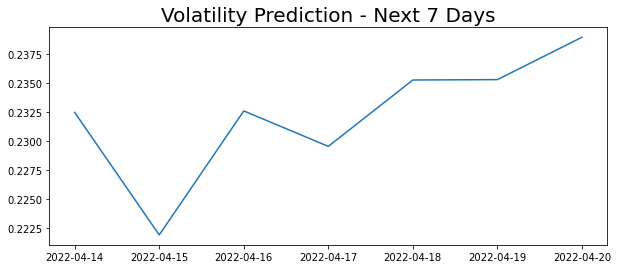

In [107]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)